In [1]:
import openaq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from aqtools import aqutils as u

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD

from noaa_sdk import noaa

api = openaq.OpenAQ()

In [22]:
# Parameter setting

date_from = '2021-09-01T00:00:00Z' # Default: PST
date_to = '2022-03-01T00:00:00Z'
city = 'San Francisco-Oakland-Fremont'
location = 'Oakland'
date_retrieval_limit = 4000

In [23]:
# co
pollutant = 'co'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_co = u.date_pollutant_value(r, pollutant)
df_co.head(3)

,date,co
3600,2021-08-31 17:00:00,0.3
3599,2021-08-31 18:00:00,0.3
3598,2021-08-31 19:00:00,0.3


In [26]:
# no2
pollutant = 'no2'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_no2 = u.date_pollutant_value(r, pollutant)

df_no2.head(3)

,date,no2
3599,2021-08-31 17:00:00,0.002
3598,2021-08-31 18:00:00,0.003
3597,2021-08-31 19:00:00,0.004


In [29]:
# o3
pollutant = 'o3'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_o3 = pd.DataFrame(data=r)
df_o3 = u.date_pollutant_value(r, pollutant)

df_o3.head(3)

,date,o3
3600,2021-08-31 17:00:00,0.031
3599,2021-08-31 18:00:00,0.031
3598,2021-08-31 19:00:00,0.030


In [33]:
# pm25
pollutant = 'pm25'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_pm25 = pd.DataFrame(data=r)
df_pm25 = u.date_pollutant_value(r, pollutant)

df_pm25.head(3)

,date,pm25
3751,2021-08-31 17:00:00,11
3750,2021-08-31 18:00:00,12
3749,2021-08-31 19:00:00,15


In [34]:
# Merge dataframes on 'date' (find the intersection of values based on 'date')
df = df_co.merge(df_no2, how='inner', on='date')
df = df.merge(df_o3, how='inner', on='date')
df = df.merge(df_pm25, how='inner', on='date')
df = df.set_index(['date'])
df

,co,no2,o3,pm25
date,,,,
2021-08-31 17:00:00,0.30,0.002,0.031,11
2021-08-31 18:00:00,0.30,0.003,0.031,12
2021-08-31 19:00:00,0.30,0.004,0.030,15
2021-08-31 20:00:00,0.36,0.006,0.029,14
2021-08-31 21:00:00,0.37,0.006,0.028,12
...,...,...,...,...
2022-02-28 12:00:00,0.47,0.025,0.023,15
2022-02-28 13:00:00,0.46,0.025,0.026,20
2022-02-28 14:00:00,0.38,0.016,0.038,13


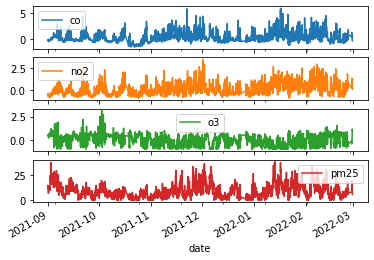

In [35]:
# MinMax Scaling
scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['co'].values.reshape(-1, 1))
df['co'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['no2'].values.reshape(-1, 1))
df['no2'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['o3'].values.reshape(-1, 1))
df['o3'] = co_scaled

df.plot(subplots=True)
plt.show()

/tmp/ipykernel_9900/3282434271.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co'] = co_diff
/tmp/ipykernel_9900/3282434271.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no2'] = no2_diff
/tmp/ipykernel_9900/3282434271.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

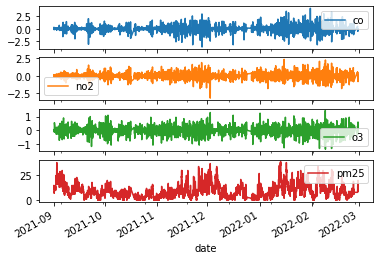

In [36]:
# Make data stationary
# Differencing technique was applied

co_diff = u.differencing(df['co'].values)
no2_diff = u.differencing(df['no2'].values)
o3_diff = u.differencing(df['o3'].values)
# Delete the first row
df = df.iloc[:-1, :]

df['co'] = co_diff
df['no2'] = no2_diff
df['o3'] = o3_diff
df.plot(subplots=True)
plt.show()

In [37]:
# correlation among features
df.corr()

,co,no2,o3,pm25
co,1.000000,0.673827,-0.623135,-0.118771
no2,0.673827,1.000000,-0.770821,-0.113108
o3,-0.623135,-0.770821,1.000000,0.080400
pm25,-0.118771,-0.113108,0.080400,1.000000


In [38]:
# feature vectors: shape (num of data, window size, num of features)
feature_np = df[['co', 'no2', 'o3']].to_numpy()

# label vactors: shape (num of data,)
label_np = df[['pm25']].to_numpy()
X = []
y = []

# how many timesteps we want to look at --> default 8 (hours)
for i in range(8, len(feature_np)):
    X.append(feature_np[i-8:i, :])
    y.append(label_np[i])

X, y = np.array(X, dtype=np.float64), np.array(y, dtype=np.float64)
X.shape, y.shape

((3517, 8, 3), (3517, 1))

In [39]:
TEST_SIZE = 300

X_train = X[:-TEST_SIZE]
y_train = y[:-TEST_SIZE]
X_test = X[-TEST_SIZE:]
y_test = y[-TEST_SIZE:]


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3217, 8, 3), (3217, 1), (300, 8, 3), (300, 1))

In [40]:
# Predict pm2.5 using Gated Recurrent Unit

model = Sequential()
model.add(GRU(units=50,
              return_sequences=True,
              input_shape=X_train[0].shape,
              activation='tanh'))
model.add(GRU(units=50, activation='tanh'))
model.add(Dense(units=2))

# Compiling the GRU
model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7,
                            momentum=0.9, nesterov=False),
              loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 8, 50)             8250      
                                                                 
 gru_5 (GRU)                 (None, 50)                15300     
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 23,652
Trainable params: 23,652
Non-trainable params: 0
_________________________________________________________________


In [41]:
# model training
#early_stop = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=10)
#model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=1, callbacks=[early_stop])

model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=1)

Epoch 1/100
22/22 [==============================] - 3s 13ms/step - loss: 62.9960
Epoch 2/100
22/22 [==============================] - 0s 12ms/step - loss: 46.5795
Epoch 3/100
22/22 [==============================] - 0s 12ms/step - loss: 45.7951
Epoch 4/100
22/22 [==============================] - 0s 13ms/step - loss: 45.5856
Epoch 5/100
22/22 [==============================] - 0s 14ms/step - loss: 43.5455
Epoch 6/100
22/22 [==============================] - 0s 13ms/step - loss: 40.7361
Epoch 7/100
22/22 [==============================] - 0s 13ms/step - loss: 40.0089
Epoch 8/100
22/22 [==============================] - 0s 12ms/step - loss: 38.8224
Epoch 9/100
22/22 [==============================] - 0s 13ms/step - loss: 38.1833
Epoch 10/100
22/22 [==============================] - 0s 14ms/step - loss: 37.4783
Epoch 11/100
22/22 [==============================] - 0s 14ms/step - loss: 38.2399
Epoch 12/100
22/22 [==============================] - 0s 14ms/step - loss: 35.9026
Epoch 13/100


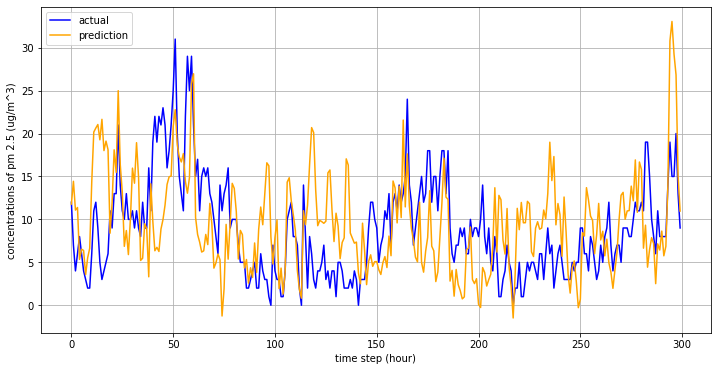

In [42]:
pred = model.predict(X_test)
pred = [p.mean() for p in pred]
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='actual', color='blue')
plt.plot(pred, label='prediction', color='orange')
plt.xlabel('time step (hour)')
plt.ylabel('concentrations of pm 2.5 (ug/m^3)')
plt.grid()
plt.legend(loc='best')
plt.show()

### Regression with wind speed and relative humidity data

In [3]:
date_from = '2022-05-02T00:00:00Z'
date_to = '2022-05-10T00:00:00Z'
city = 'San Francisco-Oakland-Fremont'
location = 'Oakland'
date_retrieval_limit = 100

date_from_utc = u.pst_to_utc(date_from)
date_to_utc = u.pst_to_utc(date_to)

In [4]:
# co
# From 2022-05-02 To 2022-05-10

pollutant = 'co'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_co = u.date_pollutant_value(r, pollutant)
df_co.head(3)

,date,co
98,2022-05-05 05:00:00,0.21
97,2022-05-05 06:00:00,0.24
96,2022-05-05 07:00:00,0.24


In [5]:
# no2
pollutant = 'no2'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_no2 = u.date_pollutant_value(r, pollutant)

df_no2.head(3)

,date,no2
99,2022-05-05 03:00:00,0.003
98,2022-05-05 05:00:00,0.004
97,2022-05-05 06:00:00,0.004


In [6]:
# o3
pollutant = 'o3'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_o3 = pd.DataFrame(data=r)
df_o3 = u.date_pollutant_value(r, pollutant)

df_o3.head(3)

,date,o3
99,2022-05-05 03:00:00,0.034
98,2022-05-05 05:00:00,0.032
97,2022-05-05 06:00:00,0.031


In [7]:
# pm25
pollutant = 'pm25'
status, resp = api.measurements(city=city,
                                location=location, parameter=pollutant,
                                date_from=date_from,
                                date_to=date_to,
                                limit=date_retrieval_limit)
r = resp['results']
df_pm25 = pd.DataFrame(data=r)
df_pm25 = u.date_pollutant_value(r, pollutant)

df_pm25.head(3)

,date,pm25
99,2022-05-05 06:00:00,8
98,2022-05-05 08:00:00,5
97,2022-05-05 09:00:00,10


In [8]:
n = noaa.NOAA()
res = n.get_observations('94603', 'US', start=date_from_utc, end=date_to_utc, num_of_stations=1)
dates = []
windspeed = []
relativehum = []

for i in res:
    dates.append(u.utc_to_pst(i['timestamp']))
    windspeed.append(i['windSpeed']['value'])
    relativehum.append(i['relativeHumidity']['value'])
df_w = pd.DataFrame()
df_w['date'] = dates
df_w['wind speed'] = windspeed
df_w['relative humidity'] = relativehum
df_w['date'] = pd.to_datetime(df_w['date'])

# fill na with median
df_w[['wind speed', 'relative humidity']] = df_w[['wind speed', 'relative humidity']].fillna(df_w[['wind speed', 'relative humidity']].median())
df_w = df_w.sort_values(by="date")
# df.to_csv('./fillna weather.csv')
df_w.head(3)

,date,wind speed,relative humidity
8,2022-05-04 05:00:00,5.40,89.091584
105,2022-05-04 06:00:00,5.40,86.202443
112,2022-05-04 07:00:00,18.36,74.290523


In [9]:
df = df_co.merge(df_no2, how='inner', on='date')
df = df.merge(df_o3, how='inner', on='date')
df = df.merge(df_w, how='inner', on='date')
df = df.merge(df_pm25, how='inner', on='date')
df = df.set_index(['date'])
df

,co,no2,o3,wind speed,relative humidity,pm25
date,,,,,,
2022-05-05 06:00:00,0.24,0.004,0.031,14.76,79.654510,8
2022-05-05 08:00:00,0.25,0.004,0.030,9.36,74.688741,5
2022-05-05 09:00:00,0.25,0.004,0.031,9.36,71.830366,10
2022-05-05 10:00:00,0.27,0.004,0.031,18.36,64.375173,10
2022-05-05 11:00:00,0.25,0.004,0.035,18.36,57.627506,7
...,...,...,...,...,...,...
2022-05-09 12:00:00,0.22,0.002,0.041,25.92,47.248268,3
2022-05-09 13:00:00,0.22,0.002,0.040,18.36,43.875674,6
2022-05-09 14:00:00,0.21,0.002,0.040,27.72,43.875674,7


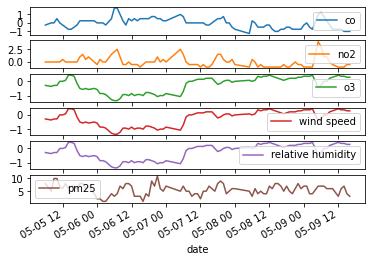

In [10]:
# MinMax Scaling
scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['co'].values.reshape(-1, 1))
df['co'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['no2'].values.reshape(-1, 1))
df['no2'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['o3'].values.reshape(-1, 1))
df['o3'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['o3'].values.reshape(-1, 1))
df['wind speed'] = co_scaled

scaler = RobustScaler()
co_scaled = scaler.fit_transform(df['o3'].values.reshape(-1, 1))
df['relative humidity'] = co_scaled

df.plot(subplots=True)
plt.show()

/tmp/ipykernel_9900/1130106116.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co'] = co_diff
/tmp/ipykernel_9900/1130106116.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no2'] = no2_diff
/tmp/ipykernel_9900/1130106116.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

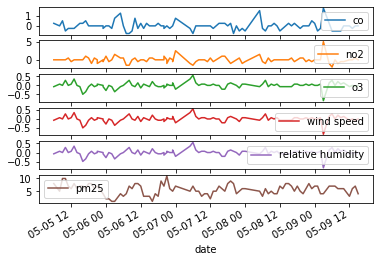

In [11]:
# Make data stationary
# Differencing technique was applied

co_diff = u.differencing(df['co'].values)
no2_diff = u.differencing(df['no2'].values)
o3_diff = u.differencing(df['o3'].values)
ws_diff = u.differencing(df['wind speed'].values)
rh_diff = u.differencing(df['relative humidity'].values)
# Delete the first row
df = df.iloc[:-1, :]

df['co'] = co_diff
df['no2'] = no2_diff
df['o3'] = o3_diff
df['wind speed'] = ws_diff
df['relative humidity'] = rh_diff
df.plot(subplots=True)
plt.show()

In [12]:
# feature vectors: shape (num of data, window size, num of features)
feature_np = df[['co', 'no2', 'o3', 'wind speed', 'relative humidity']].to_numpy()

# label vactors: shape (num of data,)
label_np = df[['pm25']].to_numpy()
X = []
y = []

# how many timesteps we want to look at --> default 8 (hours)
for i in range(8, len(feature_np)):
    X.append(feature_np[i-8:i, :])
    y.append(label_np[i])

X, y = np.array(X, dtype=np.float64), np.array(y, dtype=np.float64)
X.shape, y.shape

((91, 8, 5), (91, 1))

In [18]:
TEST_SIZE = 20

X_train = X[:-TEST_SIZE]
y_train = y[:-TEST_SIZE]
X_test = X[-TEST_SIZE:]
y_test = y[-TEST_SIZE:]


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((71, 8, 5), (71, 1), (20, 8, 5), (20, 1))

In [19]:
# Predict pm2.5 using Gated Recurrent Unit

model = Sequential()
model.add(GRU(units=50,
              return_sequences=True,
              input_shape=X_train[0].shape,
              activation='tanh'))
model.add(GRU(units=50, activation='tanh'))
model.add(Dense(units=2))

# Compiling the GRU
model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7,
                            momentum=0.9, nesterov=False),
              loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 8, 50)             8550      
                                                                 
 gru_3 (GRU)                 (None, 50)                15300     
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 23,952
Trainable params: 23,952
Non-trainable params: 0
_________________________________________________________________


In [20]:
# model training
#early_stop = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=10)
#model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=1, callbacks=[early_stop])

model.fit(X_train, y_train, epochs=100, batch_size=100, verbose=1)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 34.5210
Epoch 2/100
1/1 [==============================] - 0s 15ms/step - loss: 31.7989
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 27.0226
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 20.6984
Epoch 5/100
1/1 [==============================] - 0s 15ms/step - loss: 13.3462
Epoch 6/100
1/1 [==============================] - 0s 15ms/step - loss: 6.8651
Epoch 7/100
1/1 [==============================] - 0s 15ms/step - loss: 4.8384
Epoch 8/100
1/1 [==============================] - 0s 15ms/step - loss: 7.8960
Epoch 9/100
1/1 [==============================] - 0s 15ms/step - loss: 11.1121
Epoch 10/100
1/1 [==============================] - 0s 14ms/step - loss: 10.3757
Epoch 11/100
1/1 [==============================] - 0s 15ms/step - loss: 7.0879
Epoch 12/100
1/1 [==============================] - 0s 15ms/step - loss: 4.9053
Epoch 13/100
1/1 [==========================

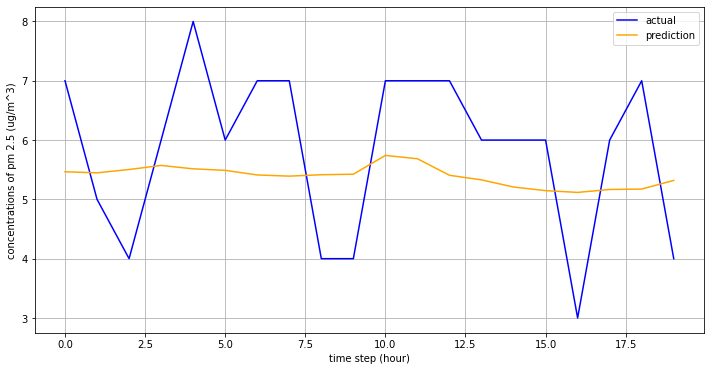

In [21]:
pred = model.predict(X_test)
pred = [p.mean() for p in pred]
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='actual', color='blue')
plt.plot(pred, label='prediction', color='orange')
plt.xlabel('time step (hour)')
plt.ylabel('concentrations of pm 2.5 (ug/m^3)')
plt.grid()
plt.legend(loc='best')
plt.show()